# Prediction Model of Omicron in the United States

1. Inputting the demographics of the US

In [ ]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# initial number of infected and recovered individuals
population = 329500000.0
e_initial = 1.0
i_initial = 0.0
r_initial = 40623844.0
v_initial = 0.0
s_initial = population - e_initial - i_initial - r_initial - v_initial

2. Inputting basic information of Omicron

In [ ]:
# parameter values
t_latent = 3
t_infective = 11
iota = float(1/14) #time for vaccine to be effective
epsilon = float(0.8) #vaccine efficacy
psi = float(0.0018) #vaccinated proportion
ar = 4.56**2 * math.pi
sigma = 1/t_latent
gamma = 1/t_infective

3. Positive percentage of the US, starting on Nov.22

In [ ]:
#data
percent_positive = np.array([6.3,
                            6.5,
                            6.6000000000000005,
                            6.9,
                            7.199999999999999,
                            7.3999999999999995,
                            7.5,
                            7.6,
                            7.7,
                            7.9,
                            7.6,
                            7.3999999999999995,
                            7.3,
                            7.3999999999999995,
                            7.3999999999999995,
                            7.3,
                            7.199999999999999,
                            7.1,
                            7.1,
                            7.1,
                            7.1,
                            7.199999999999999,
                            7.3999999999999995,
                            7.7,
                            8.1,
                            8.5,
                            8.9,
                            9.2,
                            9.9,
                            11,
                            12.3,
                            13.5,
                            14.799999999999999,
                            15.7,
                            16.5,
                            18.099999999999998,
                            20.200000000000003,
                            22.400000000000002,
                            24.6,
                            26,
                            26.700000000000003,
                            27.400000000000002,
                            28.000000000000004,
                            28.7,
                            29.2,
                            29.4,
                            29.4,
                            29.299999999999997,
                            29.2,
                            29.2,
                            28.999999999999996,
                            28.599999999999998,
                            28.1,
                            27.700000000000003,
                            27.500000000000004,
                            27.400000000000002,
                            27.3,
                            27.1,
                            26.700000000000003,
                            26.3,
                            26,
                            25.7,
                            25.5,
                            25,
                            24.3,
                            23.5,
                            22.5,
                            21.6,
                            21,
                            20.4,
                            19.6,
                            18.4,
                            17.2,
                            16.2,
                            15.2,
                            14.399999999999999,
                            13.900000000000002,
                            13.100000000000001,
                            12.2,
                            11.4,
                            10.6,
                            10,
                            9.5,
                            9,
                            8.4,
                            7.7,
                            7.1,
                            6.6000000000000005,
                            6.2,
                            5.8999999999999995,
                            5.7,
                            5.5,
                            5.3,
                            5,
                            4.7,
                            4.3999999999999995,
                            4.3])

delta_percentage = np.array([max(0, j / -10 + 7.5) for j in range(len(percent_positive))])
omicron_percentage = (percent_positive - delta_percentage) / (100 - delta_percentage)

4. Defining a function for solving the differential equations

In [ ]:
# SEIRV model differential equations.
def epseirv(x, t, sigma, a, gamma, epsilon, iota, psi, mu):
    stoe, stov, etoi, etoi, itor, vtor, s, e, i, r, v = x

    stoe = mu / ar * (1 - math.exp(-a * i)) * s
    stov  = psi * epsilon * s
    vtoe = mu / ar * (1 - math.exp(-a * i)) * v
    etoi   = sigma * e
    itor   = gamma * i
    vtor  = iota * v

    dsdt =  -stoe - stov
    dedt =  stoe + vtoe - etoi
    didt =  etoi - itor
    drdt =  itor + vtor
    dvdt =  stov - vtoe - vtor
    return [stoe, stov, vtoe, etoi, itor, vtor, dsdt, dedt, didt, drdt, dvdt]

def seirv(x, t, sigma, a, gamma, epsilon, iota, psi):
    stoe, stov, vtoe, etoi, itor, vtor, s, e, i, r, v = x

    stoe = a * i * (s/population) ** 1.2 #this 1.2 is the "guessed" value that I discussed in the paper.
    stov  = psi * epsilon * s
    vtoe = a * i * (v/population) ** 1.2
    etoi   = sigma * e
    itor   = gamma * i
    vtor  = iota * v

    dsdt =  -stoe - stov
    dedt =  stoe + vtoe - etoi
    didt =  etoi - itor
    drdt =  itor + vtor
    dvdt =  stov - vtoe - vtor
    return [stoe, stov, vtoe, etoi, itor, vtor, dsdt, dedt, didt, drdt, dvdt]

5. Defining a function to graph the results

In [ ]:
def plotdata(t, s=None, e=None, i=None, r=None, v=None, stoe=None, stov=None, vtoe=None, etoi=None, itor=None, vtor=None):
    # plot the data
    fig = plt.figure(figsize=(20,20))
    ax = [fig.add_subplot(421),
          fig.add_subplot(423),
          fig.add_subplot(422),
          fig.add_subplot(424)]
    date = [datetime(2021, 11, 22) + timedelta(t[i]) for i in range(len(t))]
    ax[0].plot(date, s, lw=3, label='Number of Susceptible')
    ax[0].plot(date, e, lw=3, label='Number of Exposed')
    ax[0].plot(date, i, lw=3, label='Number of Infective')
    ax[0].plot(date, r, lw=3, label='Number of Recovered')



    ax[0].set_title('Population Compartments')
    ax[0].set_xlabel('Time / days')
    ax[0].set_ylabel('Number of cases')

    residue = []
    for j in range(len(percent_positive)):
      residue.append(np.linspace((i[j] + e[j]) / population, omicron_percentage[j], 10))

    for j in range(len(percent_positive)):
      if (j < 44):
        ax[1].plot([date[j]] * 10, residue[j], color = "red", linestyle = "--")
      else:
        ax[1].plot([date[j]] * 10, residue[j], color = "purple", linestyle = "--")

    ax[1].plot(date, i / population, lw=3, label='Infective')
    ax[1].plot(date, e / population, lw=3, label='Exposed')
    ax[1].plot(date, (i + e) / population, lw=3, label='Infected')
    ax[1].plot(date[:44], omicron_percentage[:44], lw=3, label='US positive percentage')
    ax[1].plot(date[43:len(omicron_percentage)], omicron_percentage[43:], lw=3, label='US positive percentage')
    ax[1].yaxis.set_units(0.1)
    ax[1].set_title('Infected ratio')
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Cases')

    ax[2].plot(date, i + r, lw=3, label='Accumulative Cases')
    ax[2].set_xlabel('Time / days')
    ax[2].set_ylabel('Number of Cases')
    ax[2].set_title('Acculumative Cases')

    ax[3].plot(date, (stoe + vtoe) / (itor), lw=3, label='R(t)')
    ax[3].set_xlabel('Time / days')
    ax[3].set_ylabel(' ')
    ax[3].set_title('Real Time Reproducton Number')


    for a in ax:
        a.grid(True)
        a.legend()

    plt.tight_layout()

6. Initializing different variables

In [ ]:
t = np.linspace(0, 200, 200)

a = 0.0000000271
mu = 2.96

stoe_initial = (1 - math.exp(-a * i_initial)) * s_initial
stov_initial  = psi * epsilon * s_initial
vtoe_initial = (1 - math.exp(-a * i_initial)) * v_initial
etoi_initial   = sigma * e_initial
itor_initial   = gamma * i_initial
vtor_initial  = iota * v_initial

x_initial = stoe_initial, stov_initial, vtoe_initial, etoi_initial, itor_initial, vtor_initial, s_initial, e_initial, i_initial, r_initial, v_initial

stoe_initial = a * i_initial * (s_initial / population) ** 1.2
stov_initial  = psi * epsilon * s_initial
vtoe_initial = a * i_initial * (v_initial / population) ** 1.2
etoi_initial   = sigma * e_initial
itor_initial   = gamma * i_initial
vtor_initial  = iota * v_initial

x_seirv_initial = stoe_initial, stov_initial, vtoe_initial, etoi_initial, itor_initial, vtor_initial, s_initial, e_initial, i_initial, r_initial, v_initial

7. Minimizing the RSME & Graphing

1.59
1.989395230107133


<ipython-input-8-b6bf0fe222fe>:45: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(date, (stoe + vtoe) / (itor), lw=3, label='R(t)')


14.921805182634337
329180442.5067332


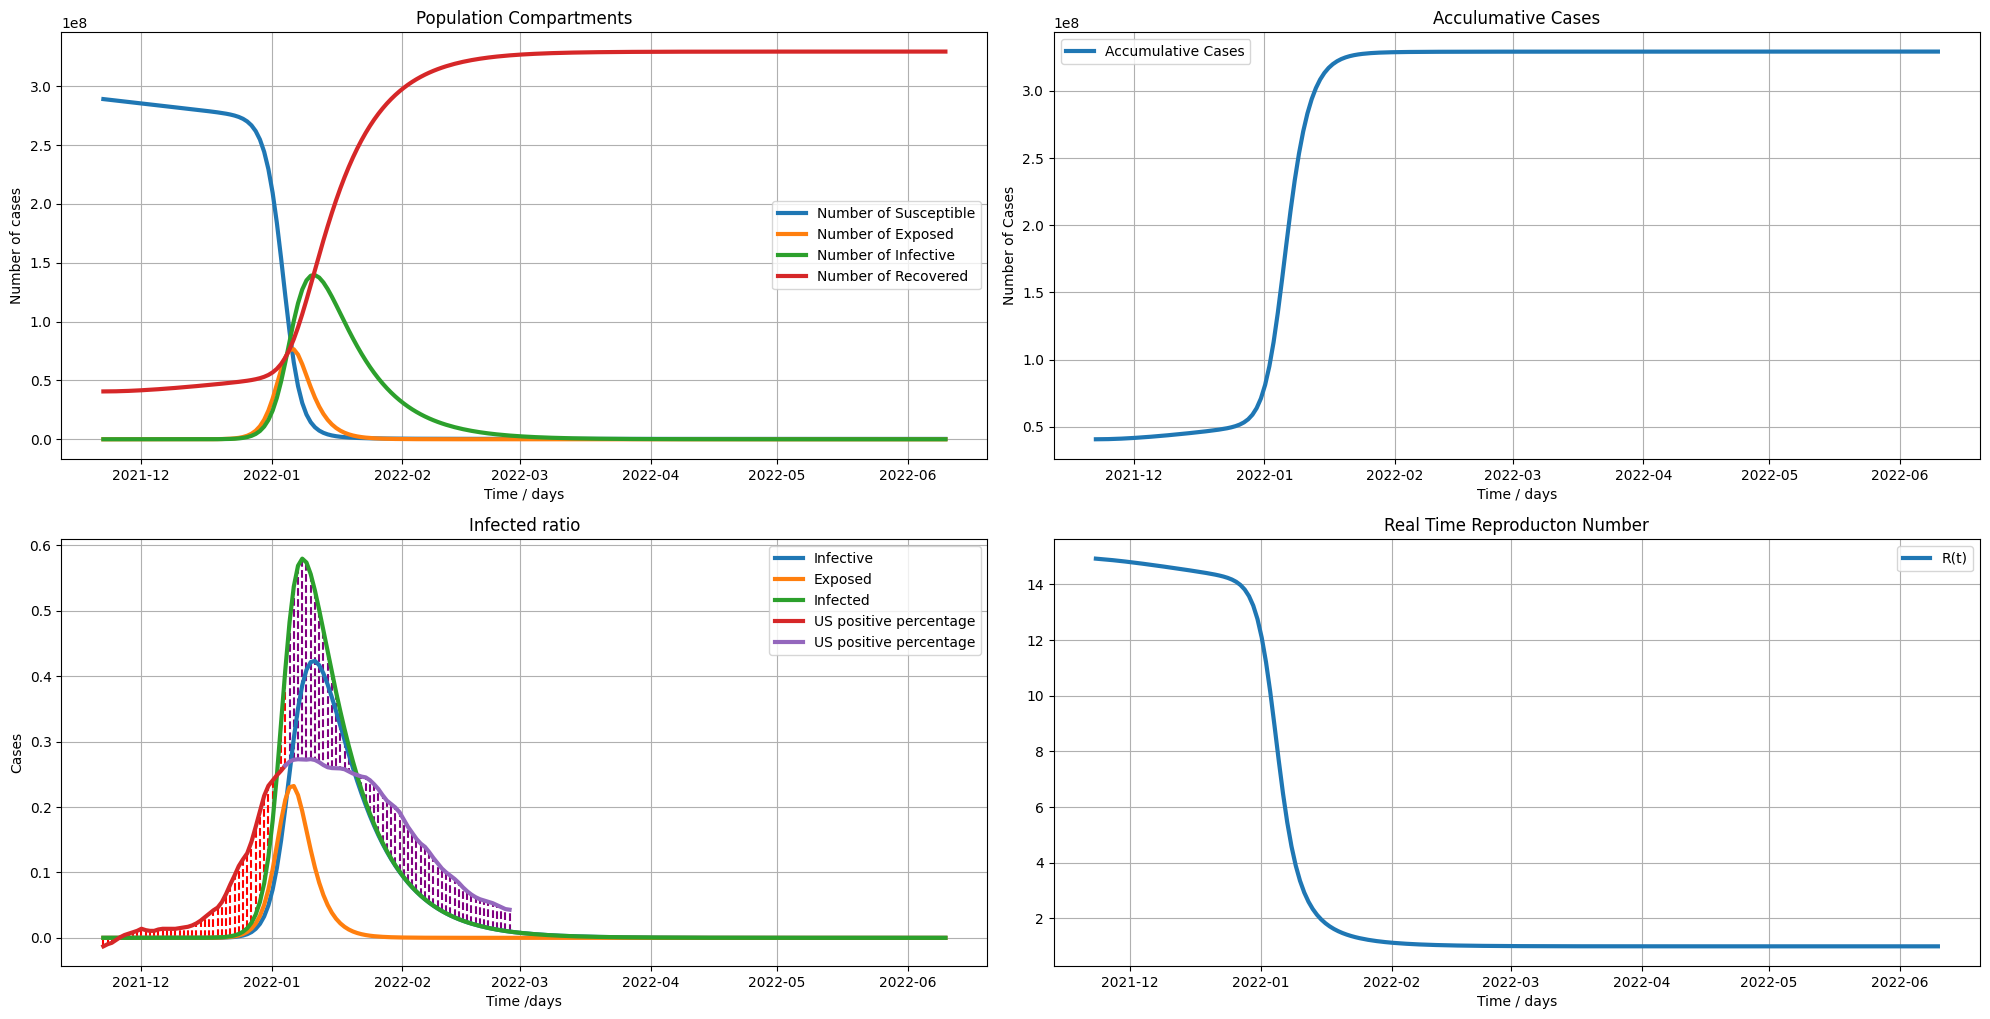

In [ ]:
min_dis = 100000000000
closest_a = 0

a = 0
for k in range(8000):
  soln = odeint(seirv, x_seirv_initial, t, args=(sigma, a + (k * 0.01), gamma, epsilon, iota, psi))
  stoe, stov, vtoe, etoi, itor, vtor, s, e, i, r, v = soln.T
  dis = 0
  for j in range(44):
    dis += abs((i[j] + e[j])/population - omicron_percentage[j])
  if (min_dis > dis):
    min_dis = dis
    closest_a = k
print(a + closest_a * 0.01)
print(min_dis)



soln = odeint(seirv, x_seirv_initial, t, args=(sigma, a + (closest_a * 0.01), gamma, epsilon, iota, psi))
stoe, stov, vtoe, etoi, itor, vtor, s, e, i, r, v = soln.T

plotdata(t, s, e, i, r, v, stoe, stov, vtoe, etoi, itor, vtor)
print((stoe[1] + vtoe[1]) / itor[1])
print(population - s[103])

<ipython-input-8-b6bf0fe222fe>:45: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(date, (stoe + vtoe) / (itor), lw=3, label='R(t)')


20.33013604933047
319673348.7497934


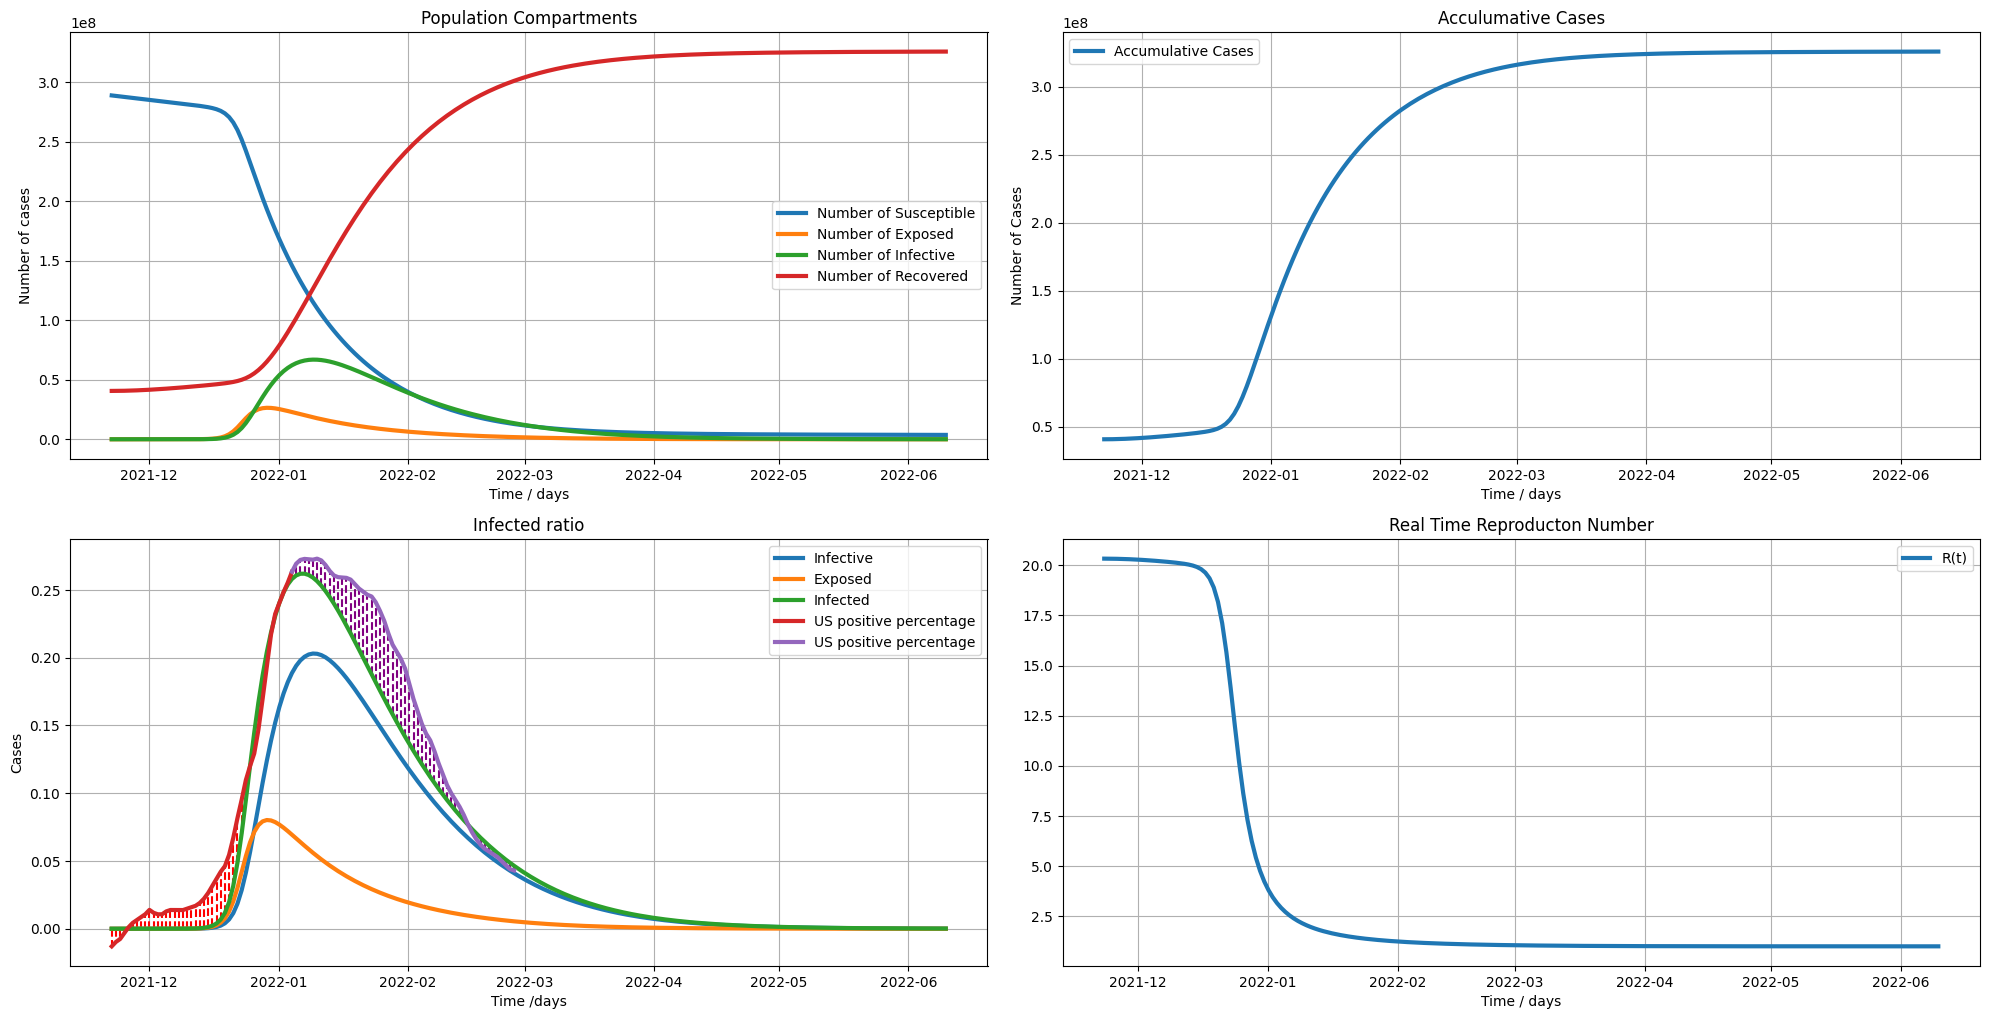

In [ ]:
min_dis = 100000000000
closest_a = 0

a = 0

for k in range(8000):
   soln = odeint(epseirv, x_initial, t, args=(sigma, a + (k * 0.0000000001), gamma, epsilon, iota, psi, mu))
   stoe, stov, vtoe, etoi, itor, vtor, s, e, i, r, v = soln.T
   dis = 0
   for j in range(44):
     dis += abs((i[j] + e[j])/population - omicron_percentage[j])
   if (min_dis > dis):
     min_dis = dis
     closest_a = k

soln = odeint(epseirv, x_initial, t, args=(sigma, a + (closest_a * 0.0000000001), gamma, epsilon, iota, psi, mu))
stoe, stov, vtoe, etoi, itor, vtor, s, e, i, r, v = soln.T

plotdata(t, s, e, i, r, v, stoe, stov, vtoe, etoi, itor, vtor)

print((stoe[1] + vtoe[1]) / itor[1])
print(population - s[103])